### Install required packages for training model


In [53]:
'''
!pip install pandas
!pip install seaborn
!pip3 install scikit-learn
!pip install gensim
!pip install tensorflow-gpu
!pip install keras
'''

'\n!pip install pandas\n!pip install seaborn\n!pip3 install scikit-learn\n!pip install gensim\n!pip install tensorflow-gpu\n!pip install keras\n'

### Import packages

In [54]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Word2vec
from gensim.models import Word2Vec

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, Conv1D, Concatenate, \
                         Bidirectional, LSTM, GlobalMaxPool1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Utils
import os
import re
import pickle
import numpy as np
import pandas as pd
import itertools

# Plots
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [55]:
# Test if GPU is avaliable
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

### Import Data

In [56]:
# Read raw dataset
dataset_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
dataset_encoding = "ISO-8859-1"
dataset = pd.read_csv('dataset/training.1600000.processed.noemoticon.csv',
                      encoding=dataset_encoding , names=dataset_columns)

# Removing the unnecessary columns.
dataset = dataset[['sentiment', 'text']]

# Replace value 4 with 1 (positive)
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Dataset result
dataset.head(3)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...


In [57]:
# Dataset distribution
dataset.groupby('sentiment').count()

,text
sentiment,
0,800000
1,800000


### Pre-Process dataset

In [58]:
# Load Enlgish contraction dictionary
contractions = pd.read_csv('dataset/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define stop words
stopwords_list = pd.read_csv('dataset/stopwords.csv', names=['Stopwords'])['Stopwords']
stopwords_list = list(stopwords_list)

# Define text cleaning pattern
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Define emojis cleaning pattern
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [59]:
def preprocess(text):
    
    # 1, Convert to lower case
    text = text.lower()

    # 2, Replace all URls with '<url>'
    text = re.sub(urlPattern, '<url>', text)
    
    # 3, Replace all @USERNAME to '<user>'.
    text = re.sub(userPattern, '<user>', text)
    
    # 4, Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(sequencePattern, seqReplacePattern, text)

    # 5, Replace all emojis.
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smileemoji, '<smile>', text)
    text = re.sub(sademoji, '<sadface>', text)
    text = re.sub(neutralemoji, '<neutralface>', text)
    text = re.sub(lolemoji, '<lolface>', text)

    # 6, Remove Contractions
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)

    # 7, Remove stop words
    # This step some how make accuracy worse
    # text = ' '.join([word for word in text.split() if word not in stopwords_list])
    
    # 8, Removing Non-Alphabets and replace them with a space
    text = re.sub(alphaPattern, ' ', text)

    # 9, Adding space on either side of '/' to seperate words.
    text = re.sub(r'/', ' / ', text)
    
    return text

In [60]:
# Show processed result of a sample text
sample_text = dataset.iloc[2]["text"]
print("Original  Text: ", sample_text)
print("Processed Text: ", preprocess(sample_text))

Original  Text:  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed Text:  <user> i dived many times for the ball  managed to save 50   the rest go out of bounds


In [61]:
# Clean up the text and store it in a new field
dataset['processed_text'] = dataset.text.apply(preprocess)

# Convert it to numpy
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

### Split training and testing set

In [62]:
# Spliting train test set
text_X_train, text_X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.05, 
                                                              random_state=0, stratify=y_data)
print("Training set size:", len(y_train))
print("Testing set size:", len(y_test))

Training set size: 1520000
Testing set size: 80000


### Tokenize text

In [63]:
tokenizer_path = 'models/Tokenizer.pickle'

# Load the tokenizer if previously trained
if os.path.exists(tokenizer_path):
    tokenizer = pickle.load(open(tokenizer_path, 'rb'))
    vocab_size = tokenizer.num_words
    
# Train a tokenizer
else:
    vocab_size = 100000
    tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
    tokenizer.fit_on_texts(text_X_train)
    tokenizer.num_words = vocab_size

# vocab_size = len(tokenizer.word_index) + 1
print("Total words", tokenizer.num_words)

Total words 100000


In [64]:
# Tokenize data
tokenized_X_train = tokenizer.texts_to_sequences(text_X_train)
tokenized_X_test = tokenizer.texts_to_sequences(text_X_test)

### Padding text

In [65]:
# Padding to ensure texts have consistent length
input_length = 60
X_train = pad_sequences(tokenized_X_train, maxlen=input_length)
X_test = pad_sequences(tokenized_X_test, maxlen=input_length)

# Word embedding

In [66]:
w2v_model_path = 'models/w2v-twitter-100'

# Load the word2vec model if previously trained
if os.path.exists(w2v_model_path):
    w2v_model = Word2Vec.load(w2v_model_path)
    w2v_size = w2v_model.vector_size

# Train a new word2vec model
else:
    # Parameters
    w2v_size = 100
    w2v_window = 7
    w2v_min_count = 10

    # Training set for w2v model
    w2v_training_data = list(map(lambda x: x.split(), text_X_train))

    # Defining w2v model and training it.
    w2v_model = Word2Vec(w2v_training_data,
                         vector_size = w2v_size,
                         workers = w2v_window,
                         min_count = w2v_min_count)

In [67]:
# Demonstrate result
print("Vocabulary Length:", len(w2v_model.wv.key_to_index))
print("Similar words to 'love': ")
w2v_model.wv.most_similar("love")

Vocabulary Length: 33147
Similar words to 'love': 


[('loove', 0.8314310908317566),
 ('adore', 0.7742820382118225),
 ('lovee', 0.7735409140586853),
 ('luv', 0.6996517181396484),
 ('loved', 0.6632917523384094),
 ('admire', 0.6377071738243103),
 ('miss', 0.630778431892395),
 ('loves', 0.6096831560134888),
 ('appreciate', 0.603790283203125),
 ('liked', 0.57492595911026)]

# Model Building And Training

In [68]:
# Embedding layer
def EmbeddingLayer():
    
    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    # print("Embedding Matrix Shape:", embedding_matrix.shape)

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    # Return embedding layer
    return Embedding(input_dim = vocab_size,
                     output_dim = w2v_size,
                     weights = [embedding_matrix],
                     input_length = input_length,
                     trainable = False)

### Build Model

In [69]:
# LSTM Model
def Pure_LSTM():
    model = Sequential()
    model.add(EmbeddingLayer())
    model.add(Dropout(0.5))
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


# C-LSTM Model
def C_LSTM():
    model = Sequential()
    model.add(EmbeddingLayer())
    model.add(Dropout(0.2))

    conv3 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(model.output)
    conv5 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(model.output)
    conv7 = Conv1D(64, kernel_size=7, padding='same', activation='relu')(model.output)
    concatted = Concatenate(axis=-1)([conv3, conv5, conv7])

    out = LSTM(256, activation='relu', recurrent_dropout=0.4)(concatted)
    out = Dropout(0.2)(out)

    out = Dense(64, activation='relu')(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=model.input, outputs=out)
    return model


# Bi-LSTM + CNN
def Bi_LSTM():
    model = Sequential()
    model.add(EmbeddingLayer())

    model.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPool1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

### Loading or Training Model

In [70]:
model_path = 'models/Bi_LSTM.h5'
train_model = True


# Train a new model
if train_model:
    # model = Pure_LSTM()
    # model = C_LSTM()
    model = Bi_LSTM()
    
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

# Load a model if already trained
else:
    model = keras.models.load_model(model_path)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 100)           10000000  
                                                                 
 bidirectional_8 (Bidirectio  (None, 60, 512)          731136    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 60, 256)          656384    
 nal)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 58, 128)           98432     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                      

In [71]:
# Start training
if train_model:

    # Training parameters
    epochs = 10
    batch_size = 1024

    # Define callbacks
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),\
                 EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

    # Start training
    history = model.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split = 0.1,
                        verbose = 1,
                        callbacks = callbacks)

Epoch 1/10
1336/1336 [==============================] - 43s 30ms/step - loss: 0.4134 - accuracy: 0.8089 - val_loss: 0.3735 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 2/10
1336/1336 [==============================] - 39s 29ms/step - loss: 0.3744 - accuracy: 0.8310 - val_loss: 0.3606 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 3/10
1336/1336 [==============================] - 39s 29ms/step - loss: 0.3596 - accuracy: 0.8388 - val_loss: 0.3535 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 4/10
1336/1336 [==============================] - 39s 29ms/step - loss: 0.3492 - accuracy: 0.8442 - val_loss: 0.3472 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 5/10
1336/1336 [==============================] - 39s 29ms/step - loss: 0.3407 - accuracy: 0.8486 - val_loss: 0.3442 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 6/10
1336/1336 [==============================] - 39s 29ms/step - loss: 0.3331 - accuracy: 0.8523 - val_loss: 0.3479 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 7/10
1336/1336 [========================

### Evaluate

In [72]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Model loss: ", score[0])
print("Model accuracy: ", score[1])

79/79 [==============================] - 1s 10ms/step - loss: 0.3561 - accuracy: 0.8453
Model loss:  0.3560941517353058
Model accuracy:  0.8452749848365784


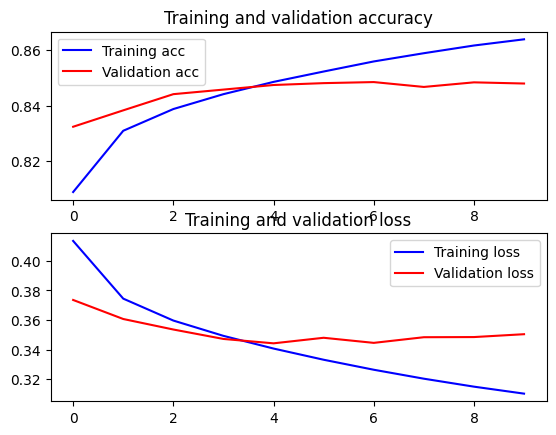

In [73]:
# Print history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.subplot(2, 1, 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()

### Test with some samples

In [74]:
def predict(text):
    # Pre-process text
    processed_text = preprocess(text)
    # Tokenize text
    input_matrix = pad_sequences(tokenizer.texts_to_sequences([processed_text]), maxlen=input_length)
    # Predict
    score = model.predict([input_matrix], verbose = 0)[0]
    
    return float(score)

In [75]:
def analyze_sentiment(text):
    print("The score of '{0}' is: {1}".format(text, predict(text)))

analyze_sentiment("I love the music!!")
analyze_sentiment("I hate the rain :(")
analyze_sentiment("i don't know what i'm doing")

The score of 'I love the music!!' is: 0.9929157495498657
The score of 'I hate the rain :(' is: 0.04760536551475525
The score of 'i don't know what i'm doing' is: 0.2574569284915924


# Model Analysis

### Evaluation

In [76]:
# Predicting on the Test dataset
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.where(y_pred>=0.5, 1, 0)

79/79 [==============================] - 1s 10ms/step


### Confusion Matrix and Classification Report

In [80]:
def plot_confusion_matrix(y_test, y_pred):
    # Compute and plot the Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes  = ['Positive', 'Negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize = 12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     40000
           1       0.85      0.84      0.84     40000

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000



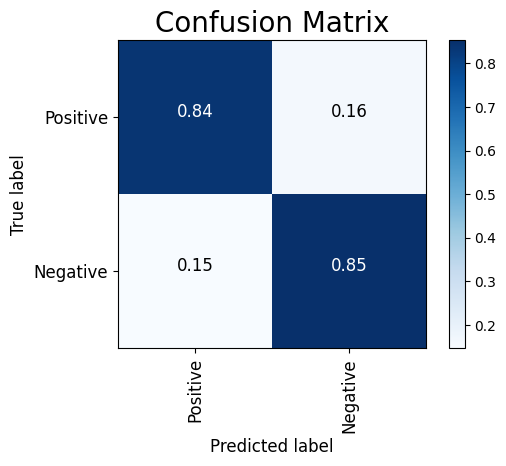

In [81]:
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Save Model

In [79]:
# Saving Word2Vec-Model
w2v_model.save(w2v_model_path)

# Saving the tokenizer
with open(tokenizer_path, 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
model.save(model_path)